In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp

import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pysindy import STLSQ

In [7]:
dt = 0.04
noise_var = 20
exp_data = LorenzExp
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 500
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=32,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)


trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 2500,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100
)

sparsifier = pySindySparsifier(STLSQ(threshold=0.5,alpha = 1.))
optimizer = AlternatingActiveSetLMSolver(
        beta_reg=0.001,
        solver_settings=optsettings,
        fixed_colloc_weight=100.,
        fixed_data_weight=1.,
        max_inner_iterations=500,
        sparsifier=sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=expdata.feature_names
)
model.fit(
    expdata.t_train,
    expdata.x_train,
    expdata.t_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(19.46181835, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 100.0}
Warm Start


  0%|          | 0/2500 [00:00<?, ?it/s]

Iteration 0, loss = 4.003e+06, gradnorm = 3.661e+07, alpha = 4.167, improvement_ratio = 0.9283
Iteration 1, loss = 9.867e+05, gradnorm = 1.957e+08, alpha = 4.167, improvement_ratio = 0.7549
Iteration 2, loss = 3.697e+05, gradnorm = 6.185e+07, alpha = 4.167, improvement_ratio = 0.63
Iteration 3, loss = 1.881e+05, gradnorm = 4.361e+07, alpha = 4.167, improvement_ratio = 0.5011
Iteration 4, loss = 4.745e+04, gradnorm = 2.09e+07, alpha = 4.167, improvement_ratio = 0.7776
Iteration 5, loss = 1.165e+04, gradnorm = 1.032e+07, alpha = 3.472, improvement_ratio = 0.8892
Iteration 100, loss = 7.038e+03, gradnorm = 1.722e+04, alpha = 0.1565, improvement_ratio = 0.4322
Line Search Failed!
Final Iteration Results
Iteration 183, loss = 7.025e+03, gradnorm = 0.02739, alpha = 1.327e+03, improvement_ratio = -3.356e+04
Model after smooth warm start
(x)' = 58.781 1 + -8.950 x + 8.901 y + -7.427 z + -1.382 x^2 + 1.997 x y + -0.079 x z + -0.707 y^2 + 0.138 y z + 0.223 z^2
(y)' = -70.314 1 + 28.355 x + -1.12

In [8]:
metrics

{'coeff_mets': {'precision': 0.875,
  'recall': 1.0,
  'f1': 0.9333333333333333,
  'coeff_rel_l2': 0.1553223049683917,
  'coeff_rmse': 0.89410940545648,
  'coeff_mae': 0.27007917279991905},
 'data_mets': {'mse': Array(45.32268962, dtype=float64),
  'rmse': np.float64(6.732212832420321),
  'mae': np.float64(4.683490940370207),
  'max_abs_error': np.float64(30.64463799317798),
  'normalized_mse': Array(0.01165004, dtype=float64),
  'relative_l2_error': np.float64(0.10791816150859478)},
 'model_params': {'show_progress': True,
  'sigma2_est': Array(19.46181835, dtype=float64),
  'data_weight': 1.0,
  'colloc_weight': 100.0}}

In [9]:
model.print()

(x)' = -9.633 x + 10.711 y
(y)' = 25.580 x + -0.902 y + -0.907 x z
(z)' = 4.174 1 + -2.875 z + 1.032 x y


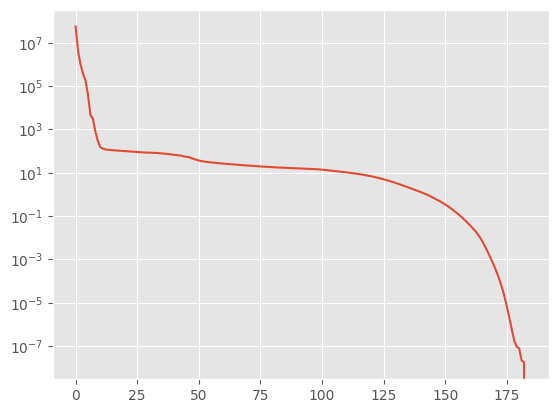

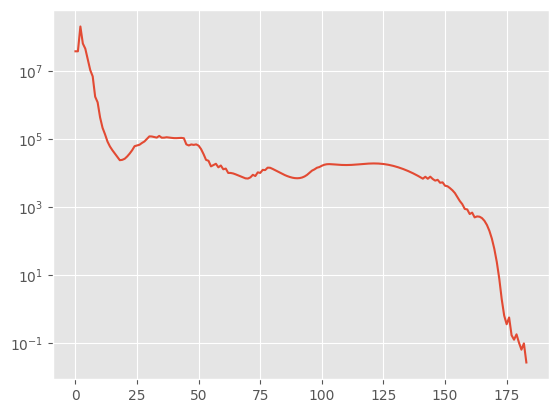

In [10]:
opt = model.opt_result[0]
plt.plot(opt.loss_vals - opt.loss_vals[-1])
plt.yscale('log')
plt.show()
plt.plot(opt.gradnorm)
plt.yscale('log')
plt.show()

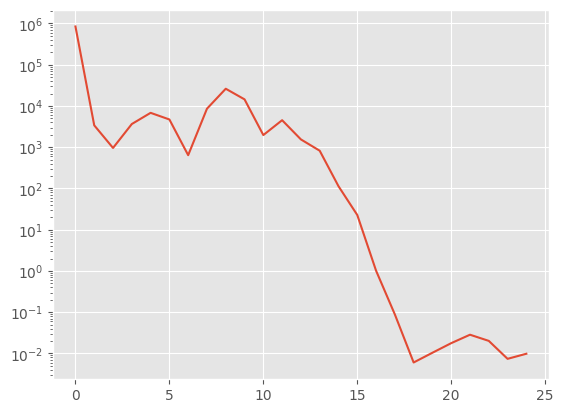

In [12]:
opt = model.opt_result[1]
plt.plot(opt.history['gnorms'][2])
plt.yscale('log')

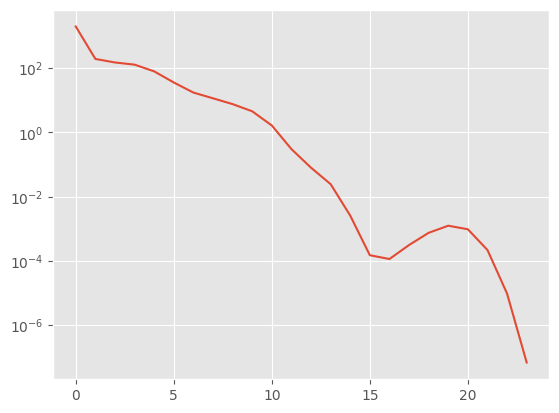

In [15]:
step_index = 2
plt.plot(-1*jnp.diff(jnp.array(opt.history['objval'][step_index])))
plt.yscale('log')

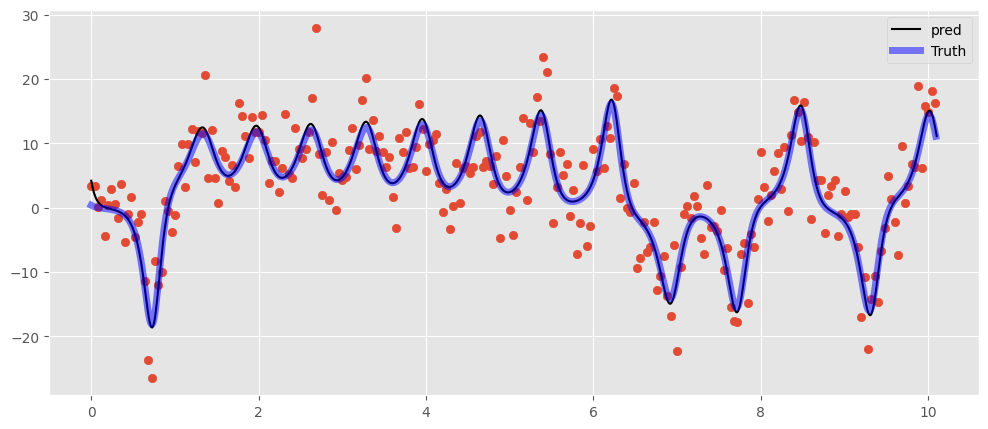

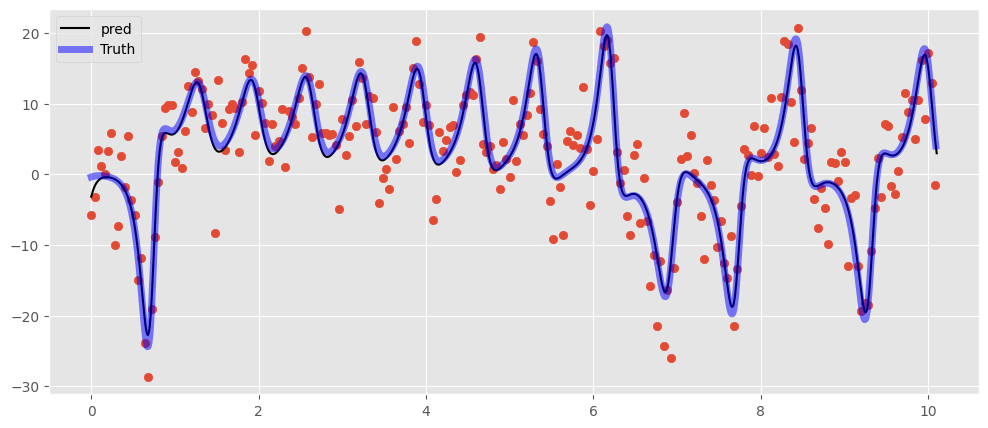

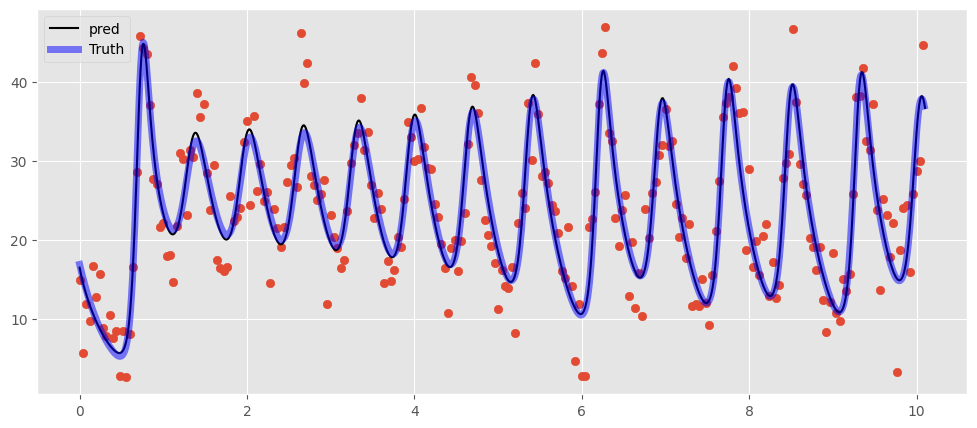

In [16]:
t_grid = jnp.linspace(0,10.1,1000)
x_pred = model.predict_state(t_grid)

for i in range(3):
    plt.figure(figsize=(12,5))
    plt.scatter(expdata.t_train,expdata.x_train[:,i])
    plt.plot(t_grid,x_pred[:,i],label = 'pred',c='black')
    plt.plot(expdata.t_true,expdata.x_true[:,i],lw = 5,alpha = 0.5,label = 'Truth',c='blue')
    plt.legend()
    plt.show()

In [17]:
t_grid = jnp.linspace(0,10,500)

xdot_pred = model.traj_model.derivative(t_grid,model.z)
x_pred = model.predict_state(t_grid)
A = dynamics_model.feature_map(x_pred)

I = jnp.eye(A.shape[1])
refit_theta = jnp.linalg.solve(A.T@A + 0.1*I ,A.T@xdot_pred)

from pysindy import STLSQ,SR3,EnsembleOptimizer,SSR
stlsq = STLSQ(threshold = 0.25,alpha =0.01,unbias = True)
optimizer = stlsq
# EnsembleOptimizer(
#     stlsq,library_ensemble=True,
#     bagging = True,
#     n_models = 5000,
#     n_candidates_to_drop=2
#     )
# optimizer = SSR(criteria = 'model_residual',kappa = 0.1,alpha = 0.01)
optimizer.fit(A,xdot_pred)
refit_theta = jnp.array(optimizer.coef_).T

model.print(refit_theta)

(x)' = -9.633 x + 10.711 y
(y)' = 25.580 x + -0.902 y + -0.907 x z
(z)' = 4.174 1 + -2.875 z + 1.032 x y


In [18]:
jnp.mean((dynamics_model.predict(expdata.x_test,refit_theta) - expdata.x_dot_test)**2)/jnp.var(expdata.x_dot_test)

Array(0.01036379, dtype=float64)